# Introduction

Dans le cadre du cours d'agriculture en environnement controlé, nous abordons la thématique de l'agriculture indoor, ses enjeux, applications et les techniques utilisées dans sa mise en oeuvre. Parmi ces techniques, la modélisation informatique des systèmes de production figure au premier rang. S'inscrivant dans la dynamique du "digital twin", l'idée de cette approche est de réaliser un double informatique des objets constituant le système utilisé afin de pouvoir en extraire de l'information et affiner le controle, l'efficience et la compréhension du processus de production. Cette modélisation fait appel à diverses techniques parmi lesquelles figure la programmation orientée objet.

Un des paramètres cruciaux de ce système de culture est la lumière envoyée à la plante. En effet, à la différence d'une agriculture en serre, la spécificité de l'agriculture indoor est que la source de lumière utilisée est à 100% d'origine artificielle. Le controle de cet éclairage et la compréhension de ses effets en terme de spectre lumineux utilisé, efficience énergétique, flux de photons apporté ou encore de scénario d'éclairage utilisé constituent donc des enjeux majeurs du développement de ce genre de système de production. 

Par ailleurs, l'électricité consommée pour l'éclairage est assez importante et constitue un des couts principaux de production de ce genre de système. La culture des plantes ne nécessitant pas une lumière constante (en témoigne les variations dues aux nuages ou aux saisons que l'on rencontre en milieu naturel), rend cette consommation d'énergie modulable. Ce fait conjugué à l'importance des besoins en électricité rend le potentiel d'utilisation des systèmes d'agriculture indoor pour assurer la stabilité du réseau électrique assez important. 

Ces caractérisiques permettent de dégager des perspectives intéressantes pour l'agriculture indoor dans le cadre d'un développement massif des énergies renouvelables intermittentes conjugué au développement de smart-grid. Une autre application possible est d'utiliser le caractére modulable de ces installations pour adapter la consommation d'électricité au prix de l'énergie et réduire les couts de production. 

Le présent travail s'inscrit dans ce contexte et consiste donc en la réalisation d'un outil de modélisation d'une chambre de culture indoor permettant de simuler la production de plantes sous un éclairage variant avec le prix de l'électricité tout en mettant en oeuvre des techniques de programmation orientée objet.  

# Description du système modélisé et de ses composants 
Dans le cadre de ce travail, le système d'agriculture indoor modélisé est réduit à une chambre de culture et à ses différents composants. Pour simplifier notre modèle, nous réduisons la chambre de culture aux éléments suivants: 
- l'éclairage LED
- l'alimentation électrique 
- les plantes qui y sont cultivées

La température et la concentration en CO2 de cette chambre sont considérées comme constantes et le seul phénomène modélisé sera la croissance des plantes par transfert d'énergie lumineuse à la canopée. 

Afin de pouvoir de pouvoir rendre compte des spécifités de l'espèce de plante considérée dans le modèle de croissance, l'espèce de plantes et plus précisément son modèle de croissance sera modélisé. De plus, un élément scénario d'éclairage décrivant les modalités d'éclairage (durée, intensité,...) sera également modélisé. 

Un schéma de l'installation du système modélisé est donné à la figure suivante: 

<img src ="Image/schéma système.PNG" title = "schéma système" alt = "schéma système" width ="500">



# Explication du code
## Détail des packages nécessaires
L'ensemble des packages à installer pour faire tourner ce modèle est détaillé ci-dessous:

In [1]:
import numpy as np
from scipy.integrate import odeint, romberg
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## Modélisation d'une plante

Chacun des objets plante représente un individu plante cultivé dans le système modélisé. Chacune des plantes de ce système peut donc avoir un double numérique correspondant à un objet plante.

Dans ce modèle, les plantes sont modélisées assez simplement en renseignant : 
- ID_nb : un numéro d'identification permettant de l'identifier 
- ID_plant_species : le numéro d'identification correspondant à l'espèce végétale à laquelle la plante modélisée. C'est cette espèce végétale qui va conditionner le modèle de croissance utilisé pour simulation la croissance de la plante dans la chambre de culture.
- ID_chambre_culture : le numéro de la chambre de culture dans laquelle est cultivée la plante 

Un objet plante comprend également :
- Dm : un vecteur destiné à contenir les valeurs de masse sèche de la plante au cours du temps
- Fm : un vecteur destiné à contenir les valeurs de masse fraiche de la plante au cours du temps
- Cout : une variable contenant le cout de la plante engendré par l'éclairage LED nécessaire à sa croissance 

Enfin un objet plante comprend une série de fonction :
- link_objects () : permet de lier l'objet plante avec l'objet correspondant à son espèce végétale et celui correspondant à la chambre de culture dans laquelle elle est cultivée. L'espèce végétale et la chambre de culture deviennent des attributs de l'objet plante.
- Cost () : met à jour le cout de production (attribut Cout de l'objet Plante) de la plante en fonction du prix de l'électricité, du pas de temps de la simulation et de la consommation d'électricité par plante de la chambre de culture
- resol_step () : actualise, lors de chaque étape de la simulation, la masse sèche et fraiche ainsi que le cout de production de la plante en fonction du prix de l'électricité et du pas de temps de la simulation.
- results () :  rassemble et renvoie les résultats de chacunes des plantes simulées dans des vecteurs:
    - Dm : contient les masses sèches finales des différentes plantes modélisées
    - Fm : contient les masses fraiches finales des différentes plantes modélisées
    - Cout : contient les couts de production des différentes plantes modélisées
    - Prix_kg : contient les cout de production par kg de matière fraiche produite des différentes plantes modélisées

In [2]:
class Plant: 
    objs =[]
    
    def __init__(self, ID_nb, ID_plant_species, ID_chambre_culture, date_plantation):
        Plant.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_plant_species = ID_plant_species
        self.ID_chambre_culture = ID_chambre_culture
        self.Fm = []
        self.Dm = []
        self.Cout = 0
        self.date_plantation= date_plantation
    
    def Cost (self, prix, dt, conso_plante_unitaire):
        self.Cout += (prix/100)*(conso_plante_unitaire/1000)*(dt/60)
    
    @classmethod
    def link_objects (cls):
        for plant in cls.objs:
            for plant_species in Plant_species.objs:
                if plant.ID_plant_species == plant_species.ID_nb:
                    plant.plant_species = plant_species
                    plant.Dm.append(plant_species.Dm_0)
                    plant.Fm.append(plant_species.Fm_0)
            for chambre_culture in Chambre_culture.objs:
                if plant.ID_chambre_culture == chambre_culture.ID_nb:
                    plant.chambre_culture = chambre_culture
    
    @classmethod
    def resol_step (cls,prix_elec, pas_de_temps, date_simul):
        for plant in Plant.objs:
            if date_simul == plant.date_plantation :
                plant.Cost(prix_elec, pas_de_temps, plant.chambre_culture.conso_plante_unitaire)
                plant.Dm.append(plant.plant_species.dry_matter(plant.plant_species.dDmdt, plant.Dm[-1], pas_de_temps, plant.chambre_culture.PAR, plant.chambre_culture.temperature, plant.chambre_culture.CO2_air, plant.chambre_culture.nb_plantes/plant.chambre_culture.surface))
                plant.Fm.append(plant.plant_species.fresh_matter(plant.Dm[-1]))
    
    @classmethod
    def results (cls):
        Dm=[]
        Fm=[]
        Cout=[]
        Prix_kg=[]
        for plant in Plant.objs:
            Dm.append(plant.Dm[-1])
            Fm.append(plant.Fm[-1])
            Cout.append(plant.Cout)
            Prix_kg.append(plant.Cout/plant.Fm[-1])
        return Dm,Fm,Cout,Prix_kg

## Modélisation d'une espèce de plante

Les objets Plant_species représentent chacun une espèce végétale. Ils contiennent les informations nécessaires à la construction d'un modèle de croissance de la plante et typique de l'espèce considérée.

Les différents attributs des objets plantes sont les suivants : 
- ID_nb : un numéro d'identification correspondant à l'espèce modélisée
- species : le nom de l'espèce modélisée
- Dm_0 : la masse sèche d'une graine [g]. Cette valeur servira de valeur initiale de la masse sèche de la plante lors des simualions.
- Fm_0 : la masse fraiche d'une graine [g] calculée à partir de la fresh_matter (). Cette valeur servira de valeur initiale de la masse fraiche de la plante lors des simualions. 
- dDmdt () : une fonction calculant la dérivée temporelle de la masse sèche de la plante en fonction de la masse sèche et des conditions extérieures. Elle correspond à l'équation différentielle décrivant la masse sèche d'une plante au cours du temps. Cette fonction dépend de l'espèce végétale considérée.
- dry_matter () : une fonction calculant la masse sèche de la plante au temps t en résolvant l'équation dDmdt sur un laps de temps. Cette fonction dépend de l'espèce végétale considérée
- fresh_matter () : une fonction calculant la masse de matière fraiche de la plante en fonction de la masse de matière sèche. Cette fonction dépend de l'espèce végétale considérée 

In [3]:
class Plant_species:
    objs = []
    
    def __init__(self, ID_nb, ID_chambre_culture, species, Dm_0, dDmdt, dry_matter, fresh_matter):
        Plant_species.objs.append(self)
        self.ID_nb = ID_nb
        self.species = species
        self.Dm_0 = Dm_0 #[g]
        self.Fm_0 = fresh_matter(Dm_0) #[g]
        self.dDmdt = dDmdt
        self.dry_matter = dry_matter
        self.fresh_matter = fresh_matter

### Modèle de laitue 

L'espèce modélisée dans le cadre de ce travail est la laitue. La modélisation de sa croissance est réalisée sur base du modèle de croissance utilisé par (!!!!!! CITATION). Le modèle calcule une équation différentielle exprimant l'accroissement de masse sèche de la plante en fonction du temps. Cette équation est ensuite intégrée sur le pas de temps voulu pour obtenir la masse sèche de la plante. Enfin, la masse fraiche de la plante est calculée sur base de cette masse sèche en utilisant une troisième équation. 


L'équation fondamentale du modèle est bassée sur l'équation de Faquahr qui exprime l'accroissement de la matière sèche en fonction du taux d'assimilation du carbone de la canopée:

$$ \frac{d Dm}{dt} = c_{\beta}(c_{\alpha}P-R)  $$

où Dm est la masse de matière sèche \[kg\], P est le taux d'assimilation du carbone du à la photosynthèse \[kg/m².s\], R \[ kg/m².s\]est le taux de respiration de la plante exprimé en quantité de carbone consommé. $c_{\alpha}$ et $c_{\beta}$ sont deux paramètres exprimant respectivement le rendement de conversion du dioxyde de carbone en sucre et les pertes durant la conversion de sucre en matière structurelle de la plante.  

Le taux d'assimilation photosynthétique du carbone est calculé par: 

$$ P = P_{max}(1-e^{-c_{k}c_{lar,d}(1-c_{\tau})Dm}) $$

où $P_{max}$ est le taux d'assimilation photosynthétique maximal d'une surface d'un m² complétement couvert de végétation. Le deuxième terme du produit rend compte des caractéristique géométrique et optique de la canopée. En particulier, $c_{lar,d}(1-c_{\tau}$ représente le LAI de la plante. 

Le taux maximal d'assimilation photosynthétique est calculé selon : 

$$P_{max} = \frac{\epsilon I_{PAR}\sigma_{co2}(C_{CO_2}-\Gamma)}{\epsilon I_{PAR}+\sigma_{co2}(C_{CO_2}-\Gamma)} $$

où $I_{PAR}$ est le rayonnement photosynthétiquement actif \[W/m²\] arrivant sur la plante, $C_{CO_2}$ est la concentration de $CO_2$ dans l'air ambiant, $\epsilon$ est l'efficacité d'utilisation de la lumière \[kg/J\], $\sigma_{CO_2}$ \[m/s\] est la conductance de la canopée pour le transport du $CO_{2}$ et $\Gamma$ \[kg/m³\] est le point de compensation du carbone soit la concentration de $CO_2$ pour laquelle le taux d'assimilation photosynthétique est égal au taux de respiration.

Ce dernier dépend de la température selon :

$$ \Gamma = c_{\Gamma}c_{Q10,\Gamma}^{(T-20)/10}$$

où T est la température \[°C\]. 

L'efficacité d'utilisation de la lumière $\epsilon$ est calculée selon : 

$$\epsilon = c_{\epsilon}\frac{C_{CO_2}-\Gamma}{C_{CO_2}+2\Gamma}$$

La conductance de la canopée pour le transport du $CO_{2}$ est obtenu par : 

$$ \frac{1}{\sigma_{CO_2}} = \frac{1}{c_{bnd}}+\frac{1}{c_{stm}}+\frac{1}{c_{car}}$$

Le taux de respiration est quant à lui obtenu par l'équation : 

$$R = Dm (c_{resp,s}(1-c_{\tau})+c_{resp,r}c_{\tau}) c_{Q10,resp}^{(T-25)/10}$$ 


La résolution de ce système d'équation en fonction de la température, de la concentration de $CO_2$ et du PAR permet d'évaluer la dérivée temporelle de la masse sèche, dDmdt \[kg/m².s\], de la plante à tout instant. Cette équation différentielle est modélisée par la fonction lettuce_dDmdt qui prend en argument :
- Dm : la masse sèche de la plante [kg]
- t : le temps
- T : la température [°C]
- CO2_air : la concentration en CO2 de l'air ambiant [kg/m³]
- PAR : le rayonnement photosynthétiquement actif frappant la surface de la chambre de culture [W/m²]

In [4]:
def lettuce_dDmdt (Dm, t, T, CO2_air, PAR): 
    #équation différentielle exprimant la dérivée temporelle de la masse sèche d'une laitue en fonction des conditions extérieures
    #définition des constantes et des paramètres
    c_alpha = 0.68 #[-]
    c_bheta = 0.8 #[-]
    c_bnd = 0.004 #[-]
    c_car1 = -1.32 * 10**(-5) #[m/s.°C²]
    c_car2 = 5.94*10**(-4)#[m/s.°C]
    c_car3 =-2.64*10**(-3)#[m/s]
    c_eps = 17*10**(-9)#[kg/J]
    c_T = 7.32 * 10**(-5)#[kg/m³]
    c_k = 0.9 #[-]
    c_lar_d = 62.5#[m²/kg]
    c_Q10_T = 2 #[-]
    c_Q10_resp = 2 #[-]
    c_resp_s = 3.47*10**(-7)#[s-1]
    c_resp_r = 1.16*10**(-7)#[s-1]
    c_stm = 0.007 #[m/s]
    c_t = 0.07 #[-]
    c_car = 0.00396 #[m/s]
    #calcul de la conductance lumineuse de la canopée [m/s]
    sigma_co2 = ((1/c_bnd)+(1/c_stm)+(1/c_car))**(-1)      
    #calcul du point de compensation du CO2 [kg/m³]
    Gam = c_T*c_Q10_T**((T-20)/10)
    #Calcul du light use efficiency de la photosynthèse [kg/J]
    eps = c_eps*((CO2_air-Gam)/(CO2_air+2*Gam))
    #calcul du taux maximal d'assimilation photosynthétique [kg/m².s]
    P_max = (eps*PAR*sigma_co2*(CO2_air-Gam))/(eps*PAR+sigma_co2*(CO2_air-Gam))
    #calcul du taux de respiration [kg/m².s]
    R = (c_resp_s *(1-c_t)+ c_resp_r*c_t)* Dm*c_Q10_resp**(0.1*T - 2.5)
    #calcul du taux d'assimilation photosynthétique [kg/m².s]
    P = P_max *(1-np.exp(-c_k*c_lar_d*(1-c_t)*Dm))
    #calcul de la dérivée de la masse sèche d'une plante au cours du temps [kg/s]
    dDmdt = c_bheta *(c_alpha * P - R) 
    
    return dDmdt

Une fois l'équation différentielle définie, on intégre sur l'intervalle de temps voulu pour obtenir la masse sèche totale de plante. La fonction dDmdt calcule le taux d'accroissement de la masse sèche sur un mètre carré contenant une masse sèche initiale valant Dm0. Comme on peut le constater, la fonction dDmdt ne calcule le taux d'accroissement de la masse sèche d'une plante mais bien celui de la masse sèche des plantes présentes sur une surface d'un mètre carré. 

Pour obtenir l'accroissement de masse sèche d'une plante soumise aux conditions voulues (les arguments PAR, CO2_air et température de la fonction dDmdt), on divise la matière sèche pésente sur un mètre carré de chambre de culture par la densité de plante (nombre de plantes au mètre carré). De la même manière, pour obtenir l'accroissement de matière d'une plante sur un intervalle de temps donné, on multiplie la matière sèche initiale de la plante par la densité de plante pour obtenir la masse sèche initiale sur un mètre carré de chambre de culture.  

La fonction **lettuce_dry_matter** intégre la fonction dDmdt sur l'intervalle de temps dt et renvoie la valeur finale de la matière sèche de la plante sur l'intervalle de temps considéré. La résolution de l'équation différentielle dDmdt sur l'intervalle dt est réalisée par la fonction odeint. 

Les arguments pris par lettuce_dry_matter sont :
- dDmdt : la fonction calculant la dérivée temporelle de la masse sèche
- Dm_0 : la masse sèche initiale de la plante sur l'intervalle de temps dt[kg]
- dt : l'intervalle de temps considéré [minutes]
- T : la température [°C]
- CO2_air : la concentration en CO2 de l'air ambiant [kg/m³]
- PAR : le rayonnement photosynthétiquement actif frappant la surface de la chambre de culture [W/m²]
- densite_plante : le nombre de plantes par mètre carré de la chambre de culture

In [5]:
def lettuce_dry_matter (dDmdt, Dm_0, dt, PAR, T, CO2_air, densite_plante):
    #calcul de la masse de matière sèche finale d'une laitue ayant une masse sèche initiale Dm_0
    #soumise à une température T,un rayonnement photosynthétiquement actif PAR et une concentration de CO2 CO2_air
    #sur un intervalle de temps dt 
    tspan=[0,dt*60] #conversion de l'intervalle de temps en seconde
    Dm_cur = odeint (dDmdt, Dm_0*densite_plante, tspan, args= ( T, CO2_air, PAR,) )
    Dm = Dm_cur[-1]/densite_plante
    return Dm


Pour réaliser la conversion de la matière sèche d'une laitue en matière fraiche est réalisée selon l'équation :

$$ Fm = c_{fw}Dm(1-c_{\tau}) $$

où Fm est la masse fraiche \[kg\], Dm la masse sèche de la laitue \[kg\], $c_{fw}$ le rapport masse fraiche/masse sèche (considéré comme constant) et $c_{\tau}$ le rapport entre la masse sèche des racines et celle de la plante entière. 

Cette conversion est réalisée par la fonction **lettuce_fresh_matter()** qui prend en argument Dm et envoie Fm.

In [6]:
def lettuce_fresh_matter (Dm):
    #calcul de la masse de matière fraiche d'une laitue [kg/m²] en fonction de sa matière sèche    
    c_fw = 22.5#[-]
    c_t = 0.07 #[-]
    Fm = c_fw*Dm*(1-c_t)
    return Fm

Enfin, la masse d'une graine de laitue vaut 1g pour 1000 graines. La masse sèche initiale de la graine après plantation est donc considérée comme égale à la masse de la graine soit 0.001g.

In [7]:
lettuce_Dm_0 = 1*10**(-6) #[kg]

## Modélisation d'un scénario d'éclairage

Le scénario d'écairage est un des points centraux de ce travail. Il exprime la façon dont l'éclairage 

La modélisation de ce scénario est réalisée en créant un objet **Scenario** qui comprend les attributs suivants :
- **ID_nb** : un numéro d'identification
- **heure_debut** : l'heure de début d'éclairage dans la journée
- **photoperiode** : le nombre de jour d'éclairage avant la récolte des plantes
- **price_adaptation** : valeur booléenne exprimant si l'intensité de l'éclairage est adaptée en fonction du prix de l'électricité (**True**) ou reste constante (**False**)
- **PPFD_nom** : exprime l'intensité de l'éclairage dans la chambre de culture s'il reste constant [µmol photons/m².s]
- **PPFD_max** : borne supérieure de l'intensité de l'éclairage dans la chambre de culture dans le cas où l'intensité s'adapte au prix de l'électricité [µmol photons/m².s]
- **PPFD_min** : borne inférieure de l'intensité de l'éclairage dans la chambre de culture dans le cas où l'intensité s'adapte au prix de l'électricité [µmol photons/m².s]

La fonction **ajust_conso** calcule la quantité de photons à envoyer dans la chambre de culture en fonction du prix de l'électricité si l'attribut **price_adaptation** du scénario vaut True. La densité de photons est bornée entre les valeurs **PPFD_min** et **PPFD_max** et est adaptée linéairement au prix de l'électricité en fonction des prix maximal et minimal atteint sur une période déterminée. L'intenisté lumineuse voulue est calculée selon la formule :

$$PPFD = m*prix+p$$

où prix est le prix de l'électricité pour lequel on veut calculer la densité de photons. m et p sont respectivement la pente et l'ordonnée à l'origine de la droite reliant les points (PPFD_max, prix_min) et (PPFD_min, prix_max). Cela signifie que la densité de photons maximale est obtenu lorsque le prix est minimal sur la période de temps considérée et elle est minimale lorsque le prix est maximal. 

Dans le cas où l'attribut **price_adaptation** vaut False, la densité de photons n'est pas adaptée au prix de l'électricité et vaut **PPFD_nom**.


In [8]:
class Scenario: 
    objs=[]
    
    def __init__(self,ID_nb, heure_debut, photoperiode, nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min):
        Scenario.objs.append(self)
        self.ID_nb =ID_nb
        self.heure_debut=heure_debut #heure d'activation de l'éclairage 
        self.photoperiode= photoperiode #photopériode en heure
        self.nb_jour = nb_jour
        self.price_adaptation = price_adaptation
        self.PPFD_nom = PPFD_nom #µmol photons/m².s
        self.PPFD_max = PPFD_max
        self.PPFD_min = PPFD_min
        
    def ajust_conso(self, prix, prix_max, prix_min):
        if self.price_adaptation == True:
            m = (self.PPFD_min - self.PPFD_max)/(prix_max-prix_min)
            p = self.PPFD_max-m*prix_min
            PPFD= m*prix + p
        elif price_adaptation == False:
            PPFD = self.PPFD_nom
        
        return PPFD 

Dans le scénario d'éclairage utilisé dans ce travail, on fait varier le PPFD entre 100 et 500 µmol de photons/m². Le reste des caractéristiques du scénario d'éclairage utilisé est détaillé ci-dessous et peut être modifié selon les besoins de la simulation. 

In [9]:
heure_debut = 20
photoperiode = 16 #h
PPFD_nom = 300 #µmol photons/m².s
PPFD_max = 500
PPFD_min = 100
nb_jour = 50
price_adaptation = False

## Modélisation d'une LED

La modélisation d'un ampoule LED est réalisée par la création d'un objet LED. Ce dernier a pour objectif de contenir les caractéristiques techniques de l'éclairage LED utillisé pour l'éclairage de la chambre de culture. Il contient différents arguments :
- **ID_nb** : un numéro d'identification 
- **umol_nom** : le flux de photons nominal émis dans le domaine photosynthétique [µmol de photons]
- **PAR_nom** : le rayonnement photosynthétiquement actif nominal émis [W]
- **umol_max** : le flux de photons émis maximal [µmol de photons]
- **umol_min** : le flux de potons émis minimal [µmol de photons]
- **I_flux** : une fonction permettant de calculer le courant électrique nécessaire à la LED pour émettre une proportion (appelée flux dans ce travail) du flux de photons nominal. Cette fonction exprime le rendement lumineux de l'installation LED
- **P_I** : une fonction calculant la puissance consommée par la lampe lorsqu'un courant I y circule. Elle exprime le rendement énergétique de la LED. 


In [10]:
class LED:
    objs=[]
    
    def __init__(self, ID_nb, umol_nom, PAR_nom, umol_max, umol_min, I_flux, P_I):
        LED.objs.append(self)
        self.ID_nb = ID_nb
        self.umol_nom = umol_nom 
        self.PAR_nom = PAR_nom
        self.umol_max = umol_max
        self.umol_min = umol_min
        self.I_flux = I_flux 
        self.P_I = P_I

L'équipement LED utilisé pour éclairer la chambre de culture dans le cadre de ce travail est une lampe LED OSRAM GW CSSRM1.BM. 
<img src ="Image/OslonGWCSSRM1.jpg" title = "OSRAM GW CSSRM1.BM" alt = "OSRAM GW CSSRM1.BM" width ="150">

Ses caractéristiques fournies par le fabriquant sont :
- CRI : 97 
- Température : 3000K (lumière blanche)
- flux lumineux nominal  : 192 lumen (3000k, $T_{jonction}$ = 85°C, 700mA)

Son spectre d'émission relatif est donné ci-dessous : 
<img src ="Image/spectre.PNG" title = "spectre" alt = "spectre" width ="600">

Les courbes de rendements lumineux et énergétiques fournies par le fabriquant sont données ici : 
<img src ="Image/courbe rendement.PNG" title = "rendement" alt = "rendement" width ="700">

Les fonctions **I_flux** et **P_I** utilisées pour la modélisation du LED sont directement déduites de ces courbes. Une discrétisation de ces deux courbes a été effectuée et les points ainsi calculés ont été stockés dans les fichiers *flux relatif vs courant.csv* et *courant tension.csv*. Les deux fonctions, **I_flux** et **P_I** interpolant les points sont ensuite créées grâce à la fonction **interp1d**.

In [11]:
csv_courbe_flux_relatif_vs_courant = 'LED/flux relatif vs courant.csv'
dat_I_flux= pd.read_csv(csv_courbe_flux_relatif_vs_courant,delimiter = ';', header = 0, decimal = ',')
I_fct_du_flux = interp1d (dat_I_flux.iloc[:,1], dat_I_flux.iloc[:,0], kind = 'cubic')

csv_courant_vs_tension = 'LED/courant tension.csv' 
dat_V_I_P = pd.read_csv(csv_courant_vs_tension,delimiter = ';', header = 0, decimal = ',') 
P_fct_de_I = interp1d (dat_V_I_P.iloc[:,1], dat_V_I_P.iloc[:,2], kind = 'cubic')

Le flux de photons nominal et l'intensité nominale du PAR émis par la LED (pour un courant de 700mA) sont tirées de la fiche technique de l'appareil. Le détail du calcul effectué pour obtenir ces valeurs est donné en annexe. 

In [12]:
umol_nom = 3.653 #µmol de photons/s
PAR_nom = 0.6933 #Watt
umol_min = umol_nom *min (dat_I_flux.iloc[:,1]) 
umol_max = umol_nom *max (dat_I_flux.iloc[:,1]) 

## Modélisation d'une alimentation 

L'alimentation permet d'alimenter l'éclairage LED en courant continu dans la gamme de tension et de courant correspondant à l'utilisation de cet éclairage LED. Cette transformation de la tension et du courant électrique s'accompagne d'une perte d'énergie qui défini le rendement énergétique de l'alimentation. 

La modélisation de l'alimentation est assez simple : on considère que son rendement est constant quelque soit le courant, la puissance ou la tension à fournir.

L'objet Alim possède deux attributs :
- ID_nb : son numéro d'identification dans le système modélisé
- rendement : un paramètre exprimant le rendement énergétique de l'alimentation 

In [13]:
class Alim:
    objs=[]
    
    def __init__(self, ID_nb, rendement):
        Alim.objs.append(self)
        self.ID_nb = ID_nb
        self.rendement = rendement

Dans le cadre de ce travail, on considère une alimentation ayant un rendement constant de 85%.

In [14]:
rendement_alim = 0.85 

## Modélisation d'une chambre de culture

La chambre de culture est modélisée par la création d'un objet **Chambre_culture** comprenant les attributs suivants:
- **ID_nb** :  un numéro d'identification 
- **ID_LED** : le numéro d'identification de lampe LED utilisée dans la chamnbre de culture
- **ID_alim** : le numéro d'identification de l'alimentation électrique utilisée dans la chambre de culture
- **ID_scenario** : le numéro d'identification du scénario d'éclairage utilisé appliqué dans la chambre de culture
- **surface** : la surface de la chambre de culture en m²
- **nb_LED** : le nombre de lampe LED installée dans la chambre de culture
- **nb_plantes** : le nombre de plantes cultivées dans la chambre de culture
- **CO2_air** : la concentration en dioxyde de carbone de la chambre de culture en kg par m³
- **temperature** : la température dans la chambre de culture en °C
- **switch_LED** : une variable booléenne représentant l'état de l'éclairage dans la chambre de culture. Une valeur **True** signifie que l'éclairage est allumé et une valeur **False** signifie que l'éclairage est éteint.

Un objet Chambre_culture comprend également trois fonctions :
- **ppm_to_kg_m3()** : convertit une concentration une valeur de concentration en dioxyde de carbone donnée en ppm en une valeur exprimée en kg/m³. La formule utilisée est la suivante : 
$$C_{CO_2}(kg/m³)=\rho_{air}\rho_{CO_2,rel}\frac{C_{CO_2}(ppm)}{10^{6}}$$
où $\rho_{air}$ est la masse volumique de l'air et $\rho_{CO_2,rel}$ est le rapport entre la masse volumique du CO2 et celle de l'air.

- **link_objects()** : permet de lier l'objet Chambre_culture avec les objets correspondant aux différents éléments constitutifs de cette chambre de culture (alimentation, lampadaire LED) et avec l'objet Scenario décrivant le scénario d'éclairage appliqué dans la chambre de culture. L'alimentation, le lampadaire LED et le scénario d'éclairage deviennent des attributs de l'objet plante.

- **resol_step()** : actualise l'état de la chambre de culture à chaque étape de la simulation. Elle actualise l'attribut **switch_LED** en fonction de l'heure de la journée et du scénario d'éclairage appliqué et calcule :
    - la consommation électrique instannée de la chambre de culture par la formule :
    
    $$Consommation(W)=\frac{n_{LED}*P_{LED}*switch}{\eta_{alim}}$$
    
    où $n_{LED}$ est le nombre de lampes LED de la chambre de culture, $P_{LED}$ est la puissance consommée par un LED pour générer le PPFD voulu et $\eta_{alim}$ est le rendement de l'alimentation. 
    $P_{LED}$ est obtenu par la fonction **P_I** de l'objet LED convertissant le courant I circulant dans la LED en puissance consommmée par la LED. Ce courant est obtenu est obtenu par la fonction **I_flux** de l'objet LED convertissant $f_{flux_{LED}}$, le rapport entre le flux de photons émis par la LED et son flux de photons nominal. $f_{flux_{LED}}$ est obtenu par la formule :
    
    $$f_{flux_{LED}} = \frac{PPFD_{voulu}*S}{flux_{photons,nom}* n_{LED}}$$
    
    où S est la surface de la chambre de culture,$flux_{photons,nom}$ est le flux de photons nominal de LED et $PPFD_{voulu}$ est est la valeur de PPFD désirée dans la chambre de culture. Cette dernière est obtenue par la fonction **ajust_conso** de l'objet Scenario en fonction de la valeur du prix de l'électricité. 
    
    - L'intensité du rayonnement photosynthétiquement actif sur la surface de la chambre de culture:
    
    $$PAR(W/m²) = switch *n_{LED} * f_{flux_{LED}} * PAR_{nom,LED}$$
    
    où $f_{flux_{LED}}$ est le rapport entre la puissance émise par une lampe LED et sa puissance nominale et $PAR_{nom,LED}$ est la puissance nominale de l'éclairage de la lampe LED (correspondant à un courant de 700mA dans ce cas-ci). 
    - la consommation électrique instantannée générée par la culture d'une plante unitaire :
    
    $$Consommation_{plante}(W) = \frac{Consommation_{chambre}}{n_{LED}}$$
    
    Ces trois grandeurs sont stockées respectivement dans les attributs **conso**, **PAR** et **conso_plante_unitaire** de l'objet **Chambre_culture**.
    

In [15]:
class Chambre_culture:
    objs=[]
    
    def __init__(self, ID_nb, ID_LED, ID_alim, ID_scenario, surface, nb_LED, nb_plantes, CO2_air, temperature):
        Chambre_culture.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_LED = ID_LED
        self.ID_alim =ID_alim
        self.ID_scenario =ID_scenario
        self.surface = surface #[m²]
        self.nb_LED = nb_LED
        self.nb_plantes = nb_plantes
        self.ppm_to_kg_m3(CO2_air)
        self.temperature = temperature
        self.switch_LED = False
    
    def ppm_to_kg_m3 (self,CO2_air):
        rho_air = 1.225 #[kg/m³]
        rho_CO2_relative = 1.521 #masse volumique CO2/masse volumique de l'air
        self.CO2_air = (CO2_air/10**6) * rho_air* rho_CO2_relative
    
    @classmethod
    def link_objects (cls):
        for chambre_culture in cls.objs :
            for led in LED.objs :
                if chambre_culture.ID_LED == led.ID_nb:
                    chambre_culture.LED = led
                    chambre_culture.umol_max = led.umol_max*chambre_culture.nb_LED
                    chambre_culture.umol_min = led.umol_min*chambre_culture.nb_LED
            for alim in Alim.objs :
                if chambre_culture.ID_alim == alim.ID_nb:
                    chambre_culture.alim = alim   
            for scenario in Scenario.objs :
                if chambre_culture.ID_scenario == scenario.ID_nb:
                    chambre_culture.scenario = scenario
                    
    @classmethod 
    def resol_step  (cls, heure, prix_cour, prix_max, prix_min):
        for room in cls.objs :
            if (heure > room.scenario.heure_debut and heure < room.scenario.heure_debut + room.scenario.photoperiode) or (room.scenario.heure_debut + room.scenario.photoperiode > 24 and heure < (room.scenario.heure_debut +room.scenario.photoperiode-24)):
                room.switch = True
            else :
                room.switch = False
            PPFD_voulu = room.scenario.ajust_conso(prix_cour ,prix_max , prix_min)
            flux_led = (PPFD_voulu*room.surface)/(room.LED.umol_nom * room.nb_LED)
            I_voulu = room.LED.I_flux(flux_led)
            room.conso= (room.nb_LED * room.LED.P_I(I_voulu)*room.switch)/room.alim.rendement
            room.PAR= room.LED.PAR_nom * room.nb_LED * flux_led * room.switch 
            room.conso_plante_unitaire =  room.conso / room.nb_plantes  


Dans le cadre de ce travail, la chambre de culture a les caractéristiques suivantes:
- une température de 20°C
- une concentration en CO2 de 400 ppm
- 18 plantes y sont plantées. Ce chiffre correspond à la densité de plantes utilisées dans l'expérience réalisée par (!!!CITATION) qui sert de base à notre modèle. Elle a été conservée afin de ne pas s'éloigner du domaine de validité du modèle utilisé.
- une surface d'un mètre carré
- Elle contient 65 lampes LED OSRAM GW CSSRM1.BM. Ce nombre a été déterminé de manière à couvrir la gamme de PPFD à fournir de 100 à 500 µmol de photons/m² définie dans le scénario d'éclairage. Avec 65 LED, la gamme de PPFD couverte va de 38.7 µmol de photons/m² à 516 µmol de photons/m².

In [16]:
temperature = 20 #[°C]
CO2_air = 400 #ppm
nb_led_room = 65 #nombre de LED dans une chambre de culture
nb_plante_room = 18 # nombre de plante dans la chambre de culture
surface = 1 #m²

# Simulation de la croissance d'une plante dans une chambre de culture
## Paramètres de la simulation désirée
Il reste maintenant à définir les paramètres de la simulation à effectuer:

- **pas_de_temps** : exprime le pas de temps entre les différents points calculés par la simulation. Dans le cadre de ce travail, il vaut 15 minutes et correspond au pas de temps entre les données de prix de l'électricité fournie par le fichier d'entrée.
- **période_regulation** : paramètres définissant l'intervalle de temps sur lequel s'effectue l'adaptation du rayonnement des LED en fonction du prix de l'électricité. En pratique, un vecteur particulier contient à tout instant de la simulation les valeurs des prix précédents de l'électricité sur une période correspondant à période régulation. Cet historique des prix permet de calibrer la droite établissant la relation entre le prix et le rayonnement. On fait correspondre le prix maximal de l'électricité sur l'intervalle de temps considéré à la valeur minimal du rayonnement et vice-versa. On obtient donc une calibration du rayonnement en fonction de l'historique des prix de l'électricité sur la période définie. 
- **date_debut** : permet de définir la date de début de la simulation (format jour/mois/année). 
- **type_simulation** : permet de définir le type de simulation à effectuer en fonction des résultats à mettre en évidence
    - *'simple'* : réalisation d'une simulation simple d'une plante dans une chambre de culture sur base d'un scénario d'éclairage 
    - *'effet heure de debut'* : réalisation d'une simulation permettant de tester différentes heure de début d'éclairage et d'obserser leur effet sur le poids final de la plante cultivée et son prix par kilogramme produit 
    - *'effet température'* : réalisation d'une simulation permettant différentes températures de culture et d'observer leur effet sur la croissance de la plante en terme de masse produite.
    - *'effet photopériode'* : réalisation d'une simulation permettant de tester différentes durées d'éclairage de la plante et d'observer leur effet sur la croissance de la plante en terme de masse produite.et de prix au kilogramme.
    - *'effet CO2'* : réalisation d'une simulation permettant de tester différentes concentrations de CO2 de la chambre de culture et d'observer leur effet sur la croissance de la plante en terme masse produite
    - *'effet PPFD'* : réalisation d'une simulation permettant de tester différentes densité de flux de photons envoyées à la plantes, les simulations sont réalisées sans adaptation du PPFD au prix de l'électricité.
    - *'effet jour de départ'* :  réalisation d'une simulation permettant de tester différentes dates de début de simulation.
    
Attention, la réalisation de ces simulations nécessite un grand nombre de calculs et la réalisation des simulations mentionnées ci-dessus peut nécessiter un temps de calcul assez long (notamment 'effet jour de départ') pouvant être de plusieurs minutes. 

In [17]:
pas_de_temps = 15 #minutes
periode_regulation = 'journée'
date_debut = [[1,9,2018]]
type_simulation = 'simple'

## Création des objets du système 
Les objets nécessaire à la simulation sont créés sur base de la simulation voulue et des paramètres sélectionnés. Pour les simulations faisant varier un paramètre du système, on crée une plante et une version de l'objet subissant cette variation de paramètre par cas testé. Les objets sont ensuite liés entre eux.

In [18]:
if type_simulation == 'simple':
    lettuce_1= Plant(1,1,1,date_debut[0])
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    chambre_culture_1= Chambre_culture(1,1,1,1, surface, nb_led_room, nb_plante_room, CO2_air, temperature)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1, heure_debut, photoperiode, nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)

elif type_simulation == 'effet heure de debut':
    for i in np.arange (24):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+",date_debut[0])")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,"+str(i)+", surface, nb_led_room, nb_plante_room, CO2_air, temperature)")
        exec ("scenario_"+str(i)+" =Scenario ("+str(i)+","+str(i)+",photoperiode,nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)

elif type_simulation =='effet température':
    for i in np.arange (29):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+",date_debut[0])")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,1, surface, nb_led_room, nb_plante_room, CO2_air, 7 +"+str(i)+")")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1, heure_debut, photoperiode, nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)


elif type_simulation == 'effet photopériode':
    for i in np.arange (24):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+",date_debut[0])")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,"+str(i)+", surface, nb_led_room, nb_plante_room, CO2_air, temperature)")
        exec ("scenario_"+str(i)+" =Scenario ("+str(i)+",heure_debut,"+str(i)+",nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min,I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)

elif type_simulation == 'effet CO2':
    for i in np.arange (9):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+",date_debut[0])")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,1, surface, nb_led_room, nb_plante_room, 100* ("+str(i)+"+2), temperature)")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1, heure_debut, photoperiode, nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)

elif type_simulation == 'effet PPFD':
    for i in np.arange (18):
        exec ("lettuce_"+str(i)+"= Plant("+str(i)+",1,"+str(i)+",date_debut[0])")
        exec ("chambre_culture_"+str(i)+"= Chambre_culture("+str(i)+",1,1,"+str(i)+", surface, round((150 + "+str(i)+"*50)/3.65), nb_plante_room, CO2_air, temperature)")
        exec ("scenario_"+str(i)+" =Scenario ("+str(i)+",heure_debut,photoperiode,nb_jour, False, 150 + "+str(i)+"*50 , PPFD_max, PPFD_min)")
    
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)
    
elif type_simulation =='effet jour de départ':
    date_debut = [[1,1,2018],[15,1,2018],[1,2,2018],[15,2,2018],[1,3,2018],[15,3,2018],[1,4,2018],[15,4,2018],[1,5,2018],[15,5,2018],[1,6,2018],[15,6,2018],[1,7,2018],[15,7,2018],[1,8,2018],[15,8,2018],[1,9,2018],[15,9,2018],[1,10,2018],[15,10,2018],[1,11,2018],[15,11,2018],[1,12,2018],[15,12,2018]]
    #date_debut= [[1,1,2018],[15,1,2018]]
    lettuce =  Plant_species(1,1,'lettuce', lettuce_Dm_0, lettuce_dDmdt, lettuce_dry_matter, lettuce_fresh_matter)
    chambre_culture_1= Chambre_culture(1,1,1,1, surface, nb_led_room, nb_plante_room, CO2_air, temperature)
    LED_1 =LED(1, umol_nom, PAR_nom, umol_max, umol_min, I_fct_du_flux, P_fct_de_I)
    alim_1 = Alim(1,rendement_alim)
    scenario_1 =Scenario (1, heure_debut, photoperiode, nb_jour, price_adaptation, PPFD_nom, PPFD_max, PPFD_min)
    for i in np.arange (len(date_debut)):
        exec("lettuce_"+str(i)+"= Plant("+str(i)+",1,1,date_debut["+str(i)+"])")
    
Chambre_culture.link_objects()
Plant.link_objects()

## Importation des données de prix de l'électricité
L'historique des prix de l'électricité par quart d'heure en Belgique sur les années 2018 et 2019 sont importés depuis le fichier *DA prices BE NL 2018-2019.csv* et sont stockés dans la variable **prix**. La première colonne comprend les dates et heure correspondant aux données de prix qui sont contenues dans la 6ème colonne. Les dates et heures étant importées sous forme de suite de caractéres, elles sont converties en objets **datetime** par la fonction **pd.to_datetime()** pour faciliter leur manipulation.

In [19]:
prix = pd.read_csv('prix_elec/DA prices BE NL 2018-2019.csv', delimiter = ';' ,header = 0)
prix.iloc[:,0] =pd.to_datetime(prix.iloc[:,0])

## Initialisation de la simulation
Un vecteur **prix_last_day** contenant l'historique des prix sur la période précédant la simulation. Sa longueur n dépend de la variable **periode_regulation**. Au départ de la simulation, il contient l'historique des prix sur le premier journée/semaine/mois du fichier. Les variables **prix_min** et **prix_max** correspondent aux valeurs maximales et minimales du prix de l'électricité sur la période couverte par **prix_last_day** et serviront à déterminer la première fonction d'ajustement de l'éclairage au prix de l'énergie. 

Le vecteur **prix_last_day** devant être actualisé à chaque itération de la simulation, la variable **first_in** contient l'indice dans **prix_last_day** du prix le plus vieux du vecteur. 

L'indice de la ligne de données correspondant à la date de début de la simulation est calculé et stocké dans le vecteur **indice_date**.

In [20]:
if periode_regulation =='journée':
    n = (24*4)-1
elif periode_regulation =='semaine':
    n = (7*24*4)-1
elif periode_regulation =='mois':
    n = (30*24*4)-1
prix_last_day = prix.iloc[0:n,5]
prix_min = min(prix_last_day)
prix_max = max(prix_last_day)
first_in = 0

indice_date =[]
date =[]
for i in date_debut:
    i_date = 0
    while [prix.iat[i_date,0].day,prix.iat[i_date,0].month,prix.iat[i_date,0].year] != i :
        i_date +=1
    indice_date.append(i_date)


## Simulation de la croissance des plantes
Pour chacune des dates début considérées dans la simulation, la matrice contenant les prix de l'énergie est parcourue sur le nombre de jour voulu par le scénario d'éclairage et l'état du système est actualisé par les fonctions **Chambre_culture.resol_step()** et **Plant.resol_step()**.

Lors de chaque itération, les variables **prix_cour, prix_last_day, prix_min et prix_max** sont actualisées. 

Les résultats de la simulation sont stockés dans les vecteurs **Dm, Fm, Cout et Prix_kg** grâce à la fonction **Plant.results()**

In [21]:
for i in np.arange(len(indice_date)): 
    date.append(prix.iat[indice_date[i],0])
    for j in indice_date[i] + np.arange(nb_jour*24*4):
        prix_cour = prix.iat[j,5]
        prix_last_day [first_in] = prix_cour
        prix_min = min(prix_last_day)
        prix_max = max(prix_last_day)   
        if first_in == len(prix_last_day):
            first_in = 0
        else:
            first_in +=1        
        heure = prix.iat[j,0].hour

        Chambre_culture.resol_step(heure, prix_cour, prix_max, prix_min)
        Plant.resol_step(prix_cour,pas_de_temps,date_debut[i])
        

[Dm,Fm,Cout,Prix_kg]=Plant.results()

# Représentation graphique des résultats obtenus
Les résultats obtenus par les différents résultats sont donnés sous forme graphique.

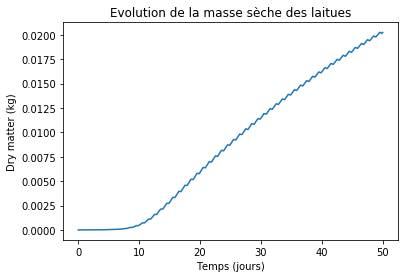

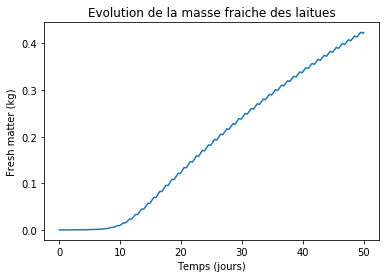

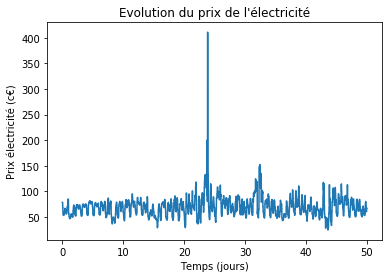

le prix de cette laitue est de5.58089102256811


In [22]:
if type_simulation == 'simple':
    plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Dm[:])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Dry matter (kg)')
    plt.title ('Evolution de la masse sèche des laitues')
    plt.show()
    plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Fm[:])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Fresh matter (kg)')
    plt.title ('Evolution de la masse fraiche des laitues')
    plt.show()
    plt.plot(np.arange(len(prix.iloc[i_date:i_date +((nb_jour*24*4)),5]))/(24*4),prix.iloc[i_date:i_date +((nb_jour*24*4)),5])
    plt.xlabel('Temps (jours)')
    plt.ylabel('Prix électricité (c€)')
    plt.title ("Evolution du prix de l'électricité")
    plt.show()
    print ('le prix de cette laitue est de'+ str(Cout[-1]))

elif type_simulation =='effet heure de debut':
    plt.plot(np.arange(24),Cout)
    plt.xlabel('Heure de début')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    plt.plot(np.arange(24),Fm)
    plt.xlabel('Heure de début')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    plt.plot(np.arange(24),Prix_kg)
    plt.xlabel('Heure de début')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de l'heure de début d'éclairage")
    plt.show()
    
elif type_simulation =='effet température':
    plt.plot(7+np.arange(len(Fm)),Fm)
    plt.xlabel('Température(°C)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la température de culture")
    plt.show()
    plt.plot(7+np.arange(len(Fm)),Prix_kg)
    plt.xlabel('Température(°C)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la température de culture")
    plt.show()
    
elif type_simulation =='effet photopériode':
    plt.plot(np.arange(24),Cout)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction de la durée de la photopériode")
    plt.show()
    plt.plot(np.arange(24),Fm)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la durée de la photopériode")
    plt.show()
    plt.plot(np.arange(24),Prix_kg)
    plt.xlabel('Photopériode (h)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la durée de la photopériode")
    plt.show()

elif type_simulation =='effet CO2':
    plt.plot(100*(np.arange(len(Fm))+2),Fm)
    plt.xlabel('Concentration de CO2 (ppm)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la concentration en CO2")
    plt.show()
    plt.plot(100*(np.arange(len(Fm))+2),Prix_kg)
    plt.xlabel('Concentration de CO2 (ppm)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la concentration en CO2")
    plt.show()
    
elif type_simulation =='effet PPFD':
    plt.plot(150+50*np.arange(18),Cout)
    plt.xlabel('PPFD(µmol photons/m².s)')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction du PPFD")
    plt.show()
    plt.plot(150+50*np.arange(18),Fm)
    plt.xlabel('PPFD(µmol photons/m².s)')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction du PPFD")
    plt.show()
    plt.plot(150+50*np.arange(18),Prix_kg)
    plt.xlabel('PPFD(µmol photons/m².s)')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction du PPFD")
    plt.show()
    
elif type_simulation =='effet jour de départ':
    plt.plot_date(date,Cout)
    plt.xlabel('date de plantation')
    plt.ylabel('Prix (€)')
    plt.title ("Prix des laitues en fonction de la date de plantation")
    plt.show()
    plt.plot(date,Fm)
    plt.xlabel('date de plantation')
    plt.ylabel('Masse des laitues (kg)')
    plt.title ("Masse des laitues en fonction de la date de plantation")
    plt.show()
    plt.plot(date,Prix_kg)
    plt.xlabel('date de plantation')
    plt.ylabel('Prix/kg (€)')
    plt.title ("Prix par kg des laitues en fonction de la date de plantation")
    plt.show()


# Quelques résultats intéressants
## Simulation simple
La courbe d'évolution de la masse sèche d'une laitue obtenue par une simulation simple est donnée ci-dessous. Elles correspondent à l'évolution de la masse des plantes cultivées selon les paramètres suivants :
- température de 20°C
- concentration en CO2 de 400 ppm
- 50 jours d'éclairage
- photopériode de 16h
- début de l'éclairage à 20h
- début de la simulation : 01/01/2018

La première courbe est obtenue pour une intensité d'éclairage constante de 300 µmol de photons/m² tandis que la deuxième est obtenue en faisant varier l'éclairage entre 100 et 500 µmol de photons/m² suivant le prix de l'électricité. 

<img src ="Image/sim_simple_300.PNG" title = "simulation 300 ppfd" alt = "simualtion 300 ppfd" width ="350">

La masse atteinte pour cette simulation est légérement supérieure à 400 g et le prix de l'électricité consommée pour cette salade est de 3.03€.

<img src ="Image/sim_simple.PNG" title = "simulation simple adaptation" alt = "simulation simple adaptation" width ="350">

La masse atteinte pour cette simulation est d'environ 350g et le prix de l'électricité consommée pour cette salade est de 2.11€.

On remarque tout d'abord que la masse de laitue est légèrement plus faible dans le cas d'une adaptation au prix de l'électricité. Cela signifie que l'adaptation au prix engendre une diminution de la moyenne du rayonnement envoyé à la plante. 

Au niveau du prix, on remarque une très nette diminution du prix de la salade (30%) dans le cas d'une adaptation au prix de l'électricité. Lorsque l'on considère le prix par kg de matière fraiche produite, on obtient une diminution de 20%. Cette diminution n'est pas négligeable et on constate ici que l'adaptation au prix de l'électricité présente un réel intérêt financier. 

D'un point de vue réalisme des résultats, on peut constater que l'allure générale des courbes est assez proches de la courbe obtenue par (!!!!!CITATION) présentée ici.

<img src ="Image/reference_sim_simple.PNG" title = "reference simulation simple" alt = "reference simulation simple" width ="350">

La courbe obtenue pour la masse sèche avec adaptation au prix de l'électricité est donnée ici:

<img src ="Image/dry weight.PNG" title = "dry weight" alt = "dry weight" width ="350">

On peut remarquer néanmoins que la croissance des plantes est plus rapide dans ce modèle. Néanmoins, les données présentées ici représentent une expérience en serre où ni la température, ni la concentration en CO2 ni l'intensité du rayonnement reçu n'étaient controlés. Un étalonnage de notre modèle par une expérience dans une chambre de culture est donc nécessaire pour avoir confiance dans les données quantitatives sorties par le modèle. 

## Effet de l'heure de départ

La courbe ci-dessous représente la comparaison entre différentes heures de début d'éclairage pour une simulation faisant varier l'éclairage en fonction du prix de l'énergie aux mêmes conditions que celles décrites au point *simulation simple*:

<img src ="Image/sim_heure.PNG" title = "simulation heure debut" alt = "simulation heure debut" width ="350">

On peut constater des variations de l'ordre de 15% en terme de prix/kg des laitues en fonction de l'heure de début du cycle d'éclairage dans la journée. Ces variations rendent compte de la variabilité du prix de l'électricité  et de sa disponibilité sur une journée. 

On constate qu'un optimum est obtenu pour une heure de départ correspondant à 19h.

## Effet du jour de départ

L'évolution du prix par kg de laitue en fonction de la date de la simulation est donnée à la figure suivante:

<img src ="Image/jour de début.PNG" title = "jour de début" alt = "jour de début" width ="350">

Cette courbe est à mettre en perspective avec la courbe traçant le prix de l'électricité au cours du temps. On y voit clairement apparaitre des pics assez importants qui peuvent expliquer en patie l'augmentation du prix sur l'année 2018.

<img src ="Image/prix électricité.PNG" title = "prix électricité" alt = "prix électricité" width ="350">

Il serait intéressant de traiter à part ces valeur particulière du prix de l'électricité anormalement haute afin de limiter l'impact des valeurs extrêmes sur l'entièreté de la simulation.

# Perspectives
La principale limite de ce modèle de culture de plante en milieu vient du fait qu'il n'est pas étalonné. La confrontation du modèle à des données expérimentales permettrait de valider les calculs et les sorties du modèle.

Ensuite, la modélisation de la chambre de culture est réalisée de manière très simplifiée et ne prend en compte tout une série de phénomène. En particulier, une modélisation des variations de la température et de la concentration en CO2 dues à la culture des plantes pourraient être ajoutées. Une autre piste serait d'affiner le modèle de photosynthèse utilisé en tenant compte notamment du specte d'émission des LED et de son efficience photosynthétique. Ce dernier aspect pourrait permettre la réponse des plantes à des rayonnements particuiers et d'optimiser le spectre de l'éclairage pour améliorer la productivité.

Enfin les estimations de prix réalisées ne tiennent compte que de l'électricité. Une prise en compte des autres couts (chauffage, solution nutritive, ...) pourrait être ajoutée pour de meilleures estimations des prix.



# Annexe
## Script calculant le flux de photons nominal et l'intensité nominale du PAR émise par une LED OSRAM GW CSSRM1.BM

In [23]:
def calc_LED ():
    
    #importation de la courbe spectrale du nombre relatif de photons émis en fonctions de la longueur d'onde
    #création d'une courbe d'interpolation 
    #calcul du nombre de photons émis en intégrant la courbe d'émission spectrale 
    #nombre de photons obtenus = nombre de photons émis par un LED ayant un pic d'émissions d'1 µmol à 630nm
    data_spec_phot_flux = pd.read_csv('LED/spectral photon flux.csv',delimiter = ';', header = 0, decimal = ',')
    spec_phot_flux = interp1d (data_spec_phot_flux.iloc[:,0], data_spec_phot_flux.iloc[:,2], kind = 'cubic')
    I= romberg(spec_phot_flux,400,780, divmax = 20)
    
    #calcul du nombre de photons émis par le LED pour un courant de 700mA 
    nb_lumen_umol = 52.56 #[lumen/umol photon/s] intensité lumineuse d'1 µmol de photons
    intensite_lumineuse_led700 = 192 #[lumen] intensité lumineuse à 700mA
    umol_led700 = intensite_lumineuse_led700/nb_lumen_umol #[µmol de photon/s] quantité de photons émis par seconde
    
    #Calcul du nombre de photons émis par 1 LED à 700mA    
    f = umol_led700/I #rapport entre la quantité émise par l'ampoule LED considérée et celle émise par l'ampoule standard
    Na = 6.022 * 10**(23)#[entité par mol] nombre d'AVOGADRO
    phot_emis= data_spec_phot_flux.iloc [:,2]*f*Na*10**(-6) #courbe donnant le nombre de photons émis par la LED en fonction de la longeur d'onde
    
    #calcul de l'énergie d'irradiance de chaque photons émis
    h = 6.63*10**(-34) #constante de Planck [J.s]
    c = 3*10**(8) #vitesse de la lumière [m/s]
    
    #création d'une courbe donnant l'énergie d'irradiance émise par la LED en fonction de la longueur d'onde
    en_emis=[]
    for i in np.arange (len(data_spec_phot_flux.iloc[:,0])):
        en_emis.append ((phot_emis [i]*h*c)/(data_spec_phot_flux.iloc[i,0]*10**(-9)))
    en_emis_lambda = interp1d (data_spec_phot_flux.iloc[:,0],en_emis,kind ='cubic')
    
    #calcul du rayonnement photosynthétiquement actif [W] en intégrant cette courbe entre 400 et 700nm  
    PAR700 = romberg (en_emis_lambda,400,700, divmax = 20)
    
    #on renvoie  le nombre de umol émis par seconde et le PAR émis par seconde pour un courant de 700mA
    return umol_led700, PAR700